The 4-class task can be decomposed in two subtasks: mass-calcification classification and benign-malignant diagnosing. The idea is to train two models independently, each focusing on one subtask only; the two networks will then work in parallel, each producing one half of the full 4-class prediction. The rationale behind this *divide et impera* approach is that each network  specializes itself to solve a smaller and potentially easier subproblem, thus getting better results than addressing the whole problem in one fell swoop.

# Environment setup

In [0]:
# Connect to Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
# Copy the dataset from Google Drive to local

!cp "/content/gdrive/My Drive/CBIS_DDSM.zip" .
!unzip -qq CBIS_DDSM.zip
!rm CBIS_DDSM.zip
cbis_path = 'CBIS_DDSM'

In [0]:
# Import libraries

%tensorflow_version 1.x
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

# Data pre-processing

In [0]:
def load_testing():
    """
    Load the test set (abnormalities patches and labels, no baseline)
    """
    images = np.load(os.path.join(cbis_path, 'numpy data', 'public_test_tensor.npy'))[1::2]
    labels = np.load(os.path.join(cbis_path, 'numpy data', 'public_test_labels.npy'))[1::2]
    return images, labels


def remap_label_type(l):
    """
    Remap the labels to:
        0 -> mass 
        1 -> calcification
    """
    if l == 1 or l == 2:
        return 0
    elif l == 3 or l == 4:
        return 1
    else:
        print("[WARN] Unrecognized label (%d)" % l)
        return None


def remap_label_severity(l):
    """
    Remap the labels to 0->benign 1->malignant
    """
    if l == 1 or l == 3:
        return 0
    elif l == 2 or l == 4:
        return 1
    else:
        print("[WARN] Unrecognized label (%d)" % l)
        return None


def combine_labels_type_severity(ltype, lsev):
    if ltype == 0 and lsev == 0:
        return 1
    elif ltype == 0 and lsev == 1:
        return 2
    elif ltype == 1 and lsev == 0:
        return 3
    elif ltype == 1 and lsev == 1:
        return 4
    else:
        print("[WARN] Unrecognized labels (%d %d)" % (ltype, lsev))
        return None

In [0]:
# Load training and test images (abnormalities only, no baseline)
test_images, test_labels= load_testing()
test_images_vgg, _ = load_testing()

# Number of images
n_test_img = test_images.shape[0]
print("Test size: %d" % (n_test_img))

# Compute width and height of images
img_w = test_images.shape[1]
img_h = test_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

test_labels_raw = test_labels.copy()

# Remap labels for mass-calc classification
test_labels_type = np.array([remap_label_type(l) for l in test_labels])

# Remap labels for benign-malignant classification
test_labels_severity = np.array([remap_label_severity(l) for l in test_labels])

# Create a new dimension for color in the images arrays
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))
test_images_vgg = test_images_vgg.reshape((n_test_img, img_w, img_h, 1))

# Rescale values to (0-1), or (0-255) for VGG
test_images = test_images.astype('uint16') / 65535
test_images_vgg = test_images_vgg.astype('uint16') / 256

# Replicate the only channel 3 times for VGG16
test_images_vgg = np.repeat(test_images_vgg, 3, axis=3)

# Normalize VGG images
preprocess_input(test_images_vgg);

Test size: 336
Image size: 150x150


# Composite model

In [0]:
!cp "/content/gdrive/My Drive/models/vgg16_ft_2layer_2cl_best.h5" .
!cp "/content/gdrive/My Drive/models/model_3_benmal_best.h5" .

# Model for mass-calcification classification
model_type = models.load_model('vgg16_ft_2layer_2cl_best.h5');
# Model for benign-malignant classification
model_severity = models.load_model('model_3_benmal_best.h5');

In [0]:
# Accuracy of the individual models on their respective tasks
_, acc_type = model_type.evaluate(test_images_vgg, test_labels_type, verbose=False)
_, acc_severity = model_severity.evaluate(test_images, test_labels_severity, verbose=False)

pred_type = np.squeeze(model_type.predict_classes(test_images_vgg)).tolist()
pred_severity = np.squeeze(model_severity.predict_classes(test_images)).tolist()

print("Standalone type accuracy: %.4f" % acc_type)
print("Standalone severity accuracy: %.4f" % acc_severity)

Standalone type accuracy: 0.9137
Standalone severity accuracy: 0.6905


In [0]:
# Get a 4-class prediction by combining two 2-class predictions
pred_combined = [combine_labels_type_severity(a, b) for a,b in zip(pred_type, pred_severity)]

combined_right = sum([p == l for p, l in zip(pred_combined, test_labels_raw)])
combined_acc = combined_right / n_test_img

print("Accuracy: %.4f" % combined_acc)
print(classification_report(test_labels_raw, pred_combined, digits=4))

Accuracy: 0.6250
              precision    recall  f1-score   support

           1     0.6961    0.6283    0.6605       113
           2     0.5135    0.5758    0.5429        66
           3     0.6975    0.7830    0.7378       106
           4     0.4390    0.3529    0.3913        51

    accuracy                         0.6250       336
   macro avg     0.5865    0.5850    0.5831       336
weighted avg     0.6216    0.6250    0.6209       336



In [0]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

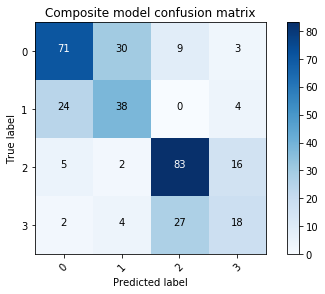

In [0]:
confusion_mtx = confusion_matrix(test_labels_raw, pred_combined) 
plot_confusion_matrix(confusion_mtx, classes=range(4), title='Composite model confusion matrix')